# Stack Overflow

## Introduction 

In the second part of this assignment, you will choose to create and analyze time series of creation dates of Stack Overflow questions, or Stack Overflow answers. You need to choose only one of the two, but please mention clearly what kind of time series you created. This assignment is to be completed **INDIVIDUALLY** and is due on **October 6 at 5pm**.

As stated above, you need to create time series of Stack Overflow questions, or answers using their creation dates. In order to do so you should use the information derived from Homework 1.1. Note that the focus of this homework is not on data collection, but on data analysis and interpretation so do not worry if you did not collect all data in the previous homework.

You are going to analyze users. If you selected to create time series of questions take the top 100 users with the most question posts, while if you created time series of answers take the top 100 users with the highest answer scores. For each user, your time series will be the number of questions (for questions), or the score value (for answers) posted by that user at some frequency. You may choose to sample your data each week, each month, on a certain day of the week or at a certain hours in a day depending on what trend you are hoping to find in the data. For example, if you choose to analyze users asking questions and sample during different hours of the day, your hypothesis could be that some users ask more questions during night hours because they are students, while others are more active during day time because they work in industry.   

Compare the time series using one of the methods discussed in class. In a few paragraphs, write down what you were hoping to find in the data (your hypothesis), what timeseries you created, what method you chose and why. Providing us with novel, or more than one hypotheses/analyses will give you extra credit. **(20 pts)**

You may find the [pandas.DataFrame.resample](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html) module helpful.

In [2]:
import xml.etree.ElementTree as etree
import time
import sys
import csv
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.datasets as sk_data
import sklearn.metrics as metrics
import seaborn as sns
from datetime import datetime


# Using the same csv outputfrom homework 1.1
df = pd.read_csv('hw2.csv', encoding = "ISO-8859-1")

In [3]:
# This block here is to convert the strings in the date to a datetime index inside the same dataframe
df['CreationDate'] = df['CreationDate'].map(lambda x: pd.to_datetime(x))

This time I want to analayze the time series of answers to see if there were different days of the week people are more active. I would hypothesize that they are most active during the weekdays, as again, these top 100 answers are probably people who are working, answering during work hours.
 
So to do this I created time series for each user in the top 100 scores, resampled them by day sized bins, then I looked up the calender of the year of the data (2015) to determine what day of the week it started it (Thursday = Jan 1st 2015). Then I made a loop to sum all the user's answers on weekdays and sum all the posts on weekends then compared them on a user by user basis, starting with euclidean pairwise distance. I also attempted to create two k++ clusters to see if this supports my hypothesis of weekday/weekend clusters of answerers.

In [4]:
# This gets me the top 100 Scores for ANSWERS
dfnoQ = df.get(df.Type != 'Q')
pd.options.mode.chained_assignment = None  # default='warn'
dfnoQ['Score'] = pd.to_numeric(dfnoQ.Score, errors='coerce').fillna(0).astype(np.int64)
dfsumscore = dfnoQ.groupby('OwnerUserId',as_index=False).agg({'Id': 'first',     #summing for the score column if the userid column is a duplicate
                                                'CreationDate': 'first',
                                                'Tags': 'first',
                                                'ViewCount': 'first',
                                                'Score':sum,
                                                'Type': 'first'}).reset_index(drop=True)

results = dfsumscore.nlargest(100,'Score')
results.index = np.arange(0,len(results))

# I want to create subset dataframes for each of the users in the top 100 scores, then sort them based on time
userdic = {}
bins = 'D'
for user in results['OwnerUserId']:
    userdic[user] = df.loc[df['OwnerUserId'] == user]
    userdic[user] = userdic[user].sort_values(['CreationDate'])
    userdic[user]['Score'] = pd.to_numeric(userdic[user]['Score'],errors='coerce')
    # Below here is where we reindex so we can convert the date to proper datetimeindex
    # then we resample for 3 hours bins
    userdic[user].set_index('CreationDate')
    userdic[user] = userdic[user].reset_index().set_index('CreationDate').Score.resample(bins).mean()
    userdic[user] = userdic[user].fillna(0)  #put 0's in for NaN returns

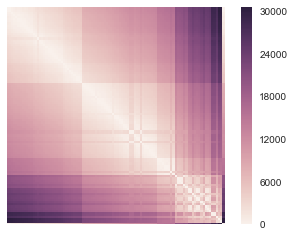

In [34]:
# Now for the fun part, lets first test our initial hypothesis and see when these top posts were most active
daily = {}
weekday = 0
weekend = 0
for user in userdic:
    for n in range(0,52):
        try:
            if n == 0:
                weekday = userdic[user][0] + userdic[user][1]
            elif n == 52:
                weekend = userdic[user][(7*(n-1))+2] + userdic[user][(7*(n-1))+3] + weekend
                weekday = userdic[user][(7*(n-1))+4] + userdic[user][(7*(n-1))+5] + userdic[user][(7*(n-1))+6] + userdic[user][(7*(n-1))+7] + weekday
            else:
                weekend = userdic[user][(7*(n-1))+2] + userdic[user][(7*(n-1))+3] + weekend
                weekday = userdic[user][(7*(n-1))+4] + userdic[user][(7*(n-1))+5] + userdic[user][(7*(n-1))+6] + userdic[user][(7*(n-1))+7] + userdic[user][(7*(n-1))+8] + weekday
        except:
            pass
    daily[user] = [weekday, weekend]
        

array = np.empty([2,])
for user in daily:
    array = np.vstack(((np.asarray(list(daily[user]))),array))
    
%matplotlib inline
pdistance = metrics.pairwise.pairwise_distances(array)
_ = sns.heatmap(pdistance, xticklabels=False, yticklabels=False, linewidths=0, square=True,cbar=True)


Plot the 2 most similar timeseries in one graph, and plot the 2 most different time series in another graph. Label your axes. **(5 pts)**

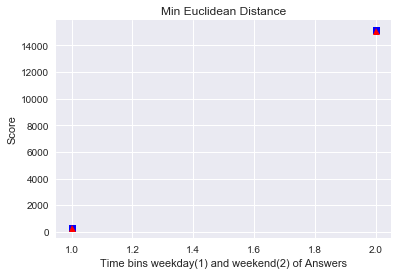

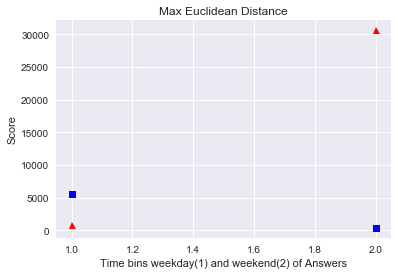

In [39]:
# These should get me the row of the user in the pairwise distance, which should be the same values as the row in the "array" function made earlier
maxdist1 = np.where(pdistance == np.max(pdistance[np.nonzero(pdistance)]))[0][0]    
mindist1 = np.where(pdistance == np.min(pdistance[np.nonzero(pdistance)]))[0][0]    
maxdist2 = np.where(pdistance == np.max(pdistance[np.nonzero(pdistance)]))[1][0]    
mindist2 = np.where(pdistance == np.min(pdistance[np.nonzero(pdistance)]))[1][0]  

# Find the users who's pairwise distance is the max and min respectively
for user in daily:
    if np.array_equal(daily[user],(array[maxdist1])):
        locmax1 = user
    if np.array_equal(daily[user],(array[maxdist2])):
        locmax2 = user

for user in daily:
    if np.array_equal(daily[user],(array[mindist1])):
        locmin1 = user 
    if np.array_equal(daily[user],(array[mindist2])):
        locmin2 = user

# Now we can plot the two max dist users and 2 min distance users together
timeaxis = np.arange(1,3)
plt.plot(timeaxis, np.asarray(daily[locmin1]), 'bs', timeaxis, np.asarray(daily[locmin2]), 'r^')
plt.ylabel('Score')
plt.xlabel('Time bins weekday(1) and weekend(2) of Answers')
plt.title('Min Euclidean Distance')
plt.show()

plt.plot(timeaxis, np.asarray(daily[locmax1]), 'bs', timeaxis, np.asarray(daily[locmax2]), 'r^')
plt.ylabel('Score')
plt.xlabel('Time bins weekday(1) and weekend(2) of Answers')
plt.title('Max Euclidean Distance')
plt.show()

What are your interpretation/conclusions from the above plotting comparisons? **(5 pts)**

Ok so it's to be expected that we have users that post at different schedules, weekdays vs weekends, but this doesn't tell me anything abotu how many people post no weekends and how many in weekdays, to do that I would need clsutering. However this is a neat proof of concept in that there are definitely differently scheduled people/habits on when they answer questions on stackexchange. Furthermore this completely disproved my hypothesis that people psot more during the weekdays, these dedicated answerers to the community clearly spend their free time during the weekends doing Gods work to struggling students/industry people alike

Choose a different distance/similarity metric and repeat the same time series analysis. **(5 pts)**

In [41]:
from sklearn.cluster import KMeans
kmeans = KMeans(init='k-means++', n_clusters=2, n_init=100)
kmeans.fit_predict(array)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_
error = kmeans.inertia_

print("The total error of the clustering is: {}.".format(error))
print('\nCluster labels:')
print(labels)


The total error of the clustering is: 2249552713.424217.

Cluster labels:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]


Ok so thats a massive error, which suggests that people post in both weekdays and weekends and its not as divisive as I had thought it would be

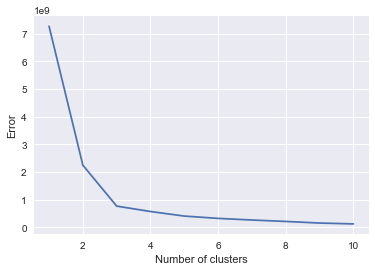

In [45]:
error = np.zeros(11)
for k in range(1,11):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
    kmeans.fit_predict(array)
    error[k] = kmeans.inertia_
    
plt.plot(range(1,len(error)),error[1:])
plt.xlabel('Number of clusters')
dummy = plt.ylabel('Error')

Looks like 3 clusters would be better, makes sens as there would be those who psot solely on weekends, solely on weekdays and then a mix, higher clusters would serve at this point to find those who's posts skew towards weekend/weekday as opposed to an even split between. I would suspect based on this prediction that there is a good portion of those who post only on weekend/weekdays exclusively

In [46]:
from sklearn.cluster import KMeans
kmeans = KMeans(init='k-means++', n_clusters=3, n_init=100)
kmeans.fit_predict(array)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_
error = kmeans.inertia_

print("The total error of the clustering is: {}.".format(error))
print('\nCluster labels:')
print(labels)

The total error of the clustering is: 772122373.1384879.

Cluster labels:
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2]


In [47]:
array
# this is the array of all the users as rows and column 1 = weekday posts, column 2 = weekend posts, this surprises me clustering
# gave me such an even spread as I'd expect, by inspection, there to be a heavy weekend skew

array([[   758.94603175,  30628.34760253],
       [   737.01190476,  30544.14045968],
       [   428.31190476,  30339.05712634],
       [   358.74202742,  30105.90117396],
       [   143.05264576,  29977.45117396],
       [   431.78479021,  29926.14745663],
       [   384.29511877,  29791.96809155],
       [   295.81959772,  29638.25618678],
       [   487.27738095,  29590.28952012],
       [   408.06428571,  29422.88952012],
       [   344.0271645 ,  29241.73356774],
       [   429.25357143,  29119.72444075],
       [   581.1702381 ,  28722.75301218],
       [   512.08650794,  28471.08158361],
       [  1783.56818182,  28295.58158361],
       [   376.49396853,  28259.08158361],
       [   490.70844156,  28125.09152645],
       [   334.04473304,  27884.89152645],
       [   642.56666667,  27629.01364044],
       [   372.84782024,  27493.41364044],
       [   418.4273088 ,  27373.77322253],
       [   485.23174603,  27246.95179396],
       [   636.39285714,  27115.25500463],
       [   

Compare the two different metrics you used and report any observations. Why did you select the specific metrics? Which do you think performed better based on the results you were expecting and why? **(5 pts)**

I used euclidean simply as a proof of concept that there are in fact people who have answers at around weekdays and weekends relatively exclusively and that there would be a divide between the two. I used clustering to determine whether weekend or weekdays were more popular as I would know which user belongs to which. However the results were suprising especially when compared to the array above that you cansee by inspection is heavily weekend skewed. The cluster labels seem to be only slightly skewed, not sure if this is truely indicative of the data shown. In either case, whether it's right or wrong, clustering performed better than raw distance for my hypothesis as it told me which users bleong to which group and hence allows me to judge it's popularity.